In [17]:
import sys
import os
import pickle
sys.path.append("/root/autodl-tmp/HSPS/IFC/")
# pkl
path = '/root/autodl-tmp/HSPS/IFC/Checkpoints/Operator/IFC_Opertor_N_1_Tprime_10.pkl'

In [18]:
import torch
torch.cuda.empty_cache()


In [19]:

# load
with open(path, 'rb') as file:
    loaded_object = pickle.load(file)



In [20]:
model = loaded_object.best_model

loaded_object.prepare_dataset(npz_path= loaded_object.config["Data_In"]["path"])

raw_data_numpy torch.Size([216, 80, 64, 100])


Text(0.5, 1.0, 'Training and Validation Loss')

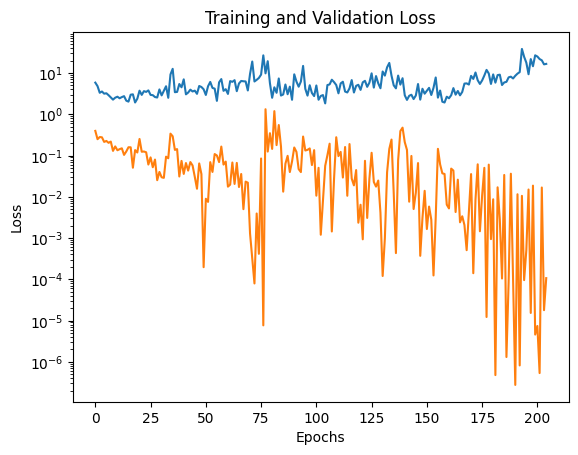

In [21]:
import matplotlib.pyplot as plt
plt.plot(loaded_object.valid_loss)
plt.plot(loaded_object.train_loss)
plt.yscale('log')

# Adding labels and title for clarity
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

In [22]:
dataloader = loaded_object.test_loader

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# 假设dataloader、model已经定义

MC_test = 50 # 50  big for uncertanity 
MC_test_DICT= {"C1":[],"C2":[],"C3":[],"C4":[]}
mc = 100 # for the T prime mc
model = model.train()
for Mc in range (MC_test):
    predictions = [[] for _ in range(4)]  # 为每个分类器预先创建列表
    true_labels_list = [[] for _ in range(4)]  # 修改变量名以避免冲突
    with torch.no_grad():
        for mc in range(50): # T_prime
            for data, conditions, label in dataloader:
                data = data.cuda()
                outputs = model(data)
                latent = model.latent  # [b, 512]

                for i in range(4):  # calssifer -4 
                    _, predicted = torch.max(outputs[:, i, :], 1)  # 获取最大值的索引作为预测类别
                    predictions[i].extend(predicted.cpu().numpy())
                    true_labels_list[i].extend(label[:, i].cpu().numpy())

        # 绘制每个分类器的预测结果的柱状图
        num_classifiers = len(predictions)
        #fig, axes = plt.subplots(num_classifiers, 2, figsize=(12, num_classifiers * 5))  # 增加图的宽度以更好地展示

        for i in range(num_classifiers):
            # ax_pred = axes[i, 0]
            # ax_true = axes[i, 1]
        
            # # 预测结果的柱状图
            # pred_labels, pred_counts = np.unique(predictions[i], return_counts=True)
            # ax_pred.bar(pred_labels, pred_counts, color='blue', alpha=0.7)
            
            # ax_pred.set_xlabel('Predicted Classes')
            # ax_pred.set_ylabel('Frequency')

            # # 真实标签的柱状图
            # true_labels, true_counts = np.unique(true_labels_list[i], return_counts=True)
            # ax_true.bar(true_labels, true_counts, color='green', alpha=0.7)
            # ax_true.set_title(f'Classifier {i+1} True')
            # ax_true.set_xlabel('True Classes')
            # ax_true.set_ylabel('Frequency')
            #将列表转换为NumPy数组以便更容易地进行运算
            preds = np.array(predictions[i])
            labels = np.array(true_labels_list[i])
            
            # 计算准确率
            accuracy = np.mean(preds == labels) * 100
            #ax_pred.set_title(f'Classifier {i+1} Predicted acc is {accuracy:.2f}%')
            MC_test_DICT[f"C{i+1}"].append(accuracy)
            print(f'In MC {Mc}Classifier {i+1} Predicted acc is {accuracy:.2f}')
        # plt.tight_layout()
        # plt.show()


In MC 0Classifier 1 Predicted acc is 91.00
In MC 0Classifier 2 Predicted acc is 94.05
In MC 0Classifier 3 Predicted acc is 89.64
In MC 0Classifier 4 Predicted acc is 100.00
In MC 1Classifier 1 Predicted acc is 91.45
In MC 1Classifier 2 Predicted acc is 93.64
In MC 1Classifier 3 Predicted acc is 89.36
In MC 1Classifier 4 Predicted acc is 100.00
In MC 2Classifier 1 Predicted acc is 91.64
In MC 2Classifier 2 Predicted acc is 93.64
In MC 2Classifier 3 Predicted acc is 89.23
In MC 2Classifier 4 Predicted acc is 100.00
In MC 3Classifier 1 Predicted acc is 91.36
In MC 3Classifier 2 Predicted acc is 93.59
In MC 3Classifier 3 Predicted acc is 89.77
In MC 3Classifier 4 Predicted acc is 100.00
In MC 4Classifier 1 Predicted acc is 91.23
In MC 4Classifier 2 Predicted acc is 93.18
In MC 4Classifier 3 Predicted acc is 89.68
In MC 4Classifier 4 Predicted acc is 100.00
In MC 5Classifier 1 Predicted acc is 91.32
In MC 5Classifier 2 Predicted acc is 93.68
In MC 5Classifier 3 Predicted acc is 89.86
In MC 

In [24]:
import numpy as np

for i in range(4):  # 对于每个分类器
   mean = np.mean(MC_test_DICT[f"C{i+1}"]) # Uncertainty
   std = np.std(MC_test_DICT[f"C{i+1}"]) # Uncertainty
   
   print(f'Classifier {i+1} Accuracy: {mean:.4f} std:{std}')


Classifier 1 Accuracy: 91.4345 std:0.33428843882279113
Classifier 2 Accuracy: 93.6336 std:0.21094239548956548
Classifier 3 Accuracy: 89.5055 std:0.2839566955693727
Classifier 4 Accuracy: 100.0000 std:0.0


In [25]:
import torch
torch.cuda.empty_cache()
